### Learning reaction types using a Random Forest classifier and different reaction fingerprints 

Goal: Include special fingerprints for agents (feature FP, Morgan2, dictionary-based FP), concatenate them with the 2048 bit reaction FP

In [1]:
import _pickle as cPickle
import gzip
from collections import defaultdict
import random
from sklearn.ensemble import RandomForestClassifier
import utilsFunctions
from pylab import rcParams

Choose some larger text size in the plots

In [2]:
rcParams.update({'font.size': 14})

In [3]:
dataDir = "../data/"


with open(dataDir+"reactionTypes_training_test_set_patent_data.pkl",'rb') as f:
    reaction_types = cPickle.load(f)
with open(dataDir+"names_rTypes_classes_superclasses_training_test_set_patent_data.pkl",'rb') as f:
    names_rTypes = cPickle.load(f)
# reaction_types = cPickle.load(file(dataDir+"reactionTypes_training_test_set_patent_data.pkl"))
# names_rTypes = cPickle.load(file(dataDir+"names_rTypes_classes_superclasses_training_test_set_patent_data.pkl"))

#### First: test the agent feature FPs

Load the FPs (reaction FP and agent feature FP)

In [6]:
infile = gzip.open(dataDir+"reaction_FPs_agentFeatureFPs_training_test_set_patent_data.pkl.gz", 'rb')

lineNo=0
fps=[]
idx=0
while 1:
    lineNo+=1
    try:
        lbl,cls,fp_woA,fp_featureAgent = cPickle.load(infile)        
    except EOFError:
        break
    fps.append([idx,lbl,cls,fp_woA,fp_featureAgent])
    idx+=1
    if not lineNo%10000:
        print("Done "+str(lineNo))

Done 10000
Done 20000
Done 30000
Done 40000
Done 50000


Build the combination of reaction FP and agent feature FPs. Split the FPs in training (20 %) and test data (80 %) per recation type (200, 800)

In [8]:
import numpy as np


random.seed(0xd00f)
indices=list(range(len(fps)))
random.shuffle(indices)

nActive=200
fpsz=2048 # the FPs bit size for converting the FPs to a numpy array
#fpsz=4096
trainFps_rFP_agentFeature=[]
trainActs=[]
testFps_rFP_agentFeature=[]
testActs=[]

print('building fp collection')

rtypes=sorted(list(reaction_types))
for i,klass in enumerate(rtypes):
    actIds = [x for x in indices if fps[x][2]==klass]
    for x in actIds[:nActive]:
        np1 = utilsFunctions.hashedFPToNPfloat(fps[x][3],fpsz)
        np2 = np.asarray(fps[x][4], dtype=float)
        trainFps_rFP_agentFeature += [np.concatenate([np1, np2])]
    trainActs += [i]*nActive
    nTest=len(actIds)-nActive
    for x in actIds[nActive:]:
        np1 = utilsFunctions.hashedFPToNPfloat(fps[x][3],fpsz)
        np2 = np.asarray(fps[x][4], dtype=float)
        testFps_rFP_agentFeature += [np.concatenate([np1, np2])]
    testActs += [i]*nTest

building fp collection


Build the RF classifier with max tree depth of 25

In [9]:
print('training model')
rf_cls = RandomForestClassifier(n_estimators=200, max_depth=25,random_state=23,n_jobs=1)
result_rf_rFP_agentFeature = rf_cls.fit(trainFps_rFP_agentFeature,trainActs)

training model


Evaluate the RF classifier using our test data

In [10]:
cmat_rFP_agentFeature = utilsFunctions.evaluateModel(result_rf_rFP_agentFeature, testFps_rFP_agentFeature, testActs, rtypes, names_rTypes)

ID  recall    prec F-score      reaction class
 0  0.9825  0.9813  0.9819     1.2.1 Aldehyde reductive amination
 1  0.9925  0.8621  0.9227     1.2.4 Eschweiler-Clarke methylation
 2  0.9812  0.9788  0.9800     1.2.5 Ketone reductive amination
 3  0.9688  0.9360  0.9521     1.3.6 Bromo N-arylation
 4  0.9800  0.9480  0.9637     1.3.7 Chloro N-arylation
 5  0.9888  0.9717  0.9802     1.3.8 Fluoro N-arylation
 6  0.9087  0.9099  0.9093     1.6.2 Bromo N-alkylation
 7  0.8900  0.9648  0.9259     1.6.4 Chloro N-alkylation
 8  0.7475  0.8260  0.7848     1.6.8 Iodo N-alkylation
 9  0.9800  0.9159  0.9469     1.7.4 Hydroxy to methoxy
10  0.9513  0.9694  0.9603     1.7.6 Methyl esterification
11  0.9325  0.9626  0.9473     1.7.7 Mitsunobu aryl ether synthesis
12  0.8950  0.9808  0.9359     1.7.9 Williamson ether synthesis
13  0.9888  0.9405  0.9640     1.8.5 Thioether synthesis
14  0.9387  0.9411  0.9399    10.1.1 Bromination
15  0.9575  0.9445  0.9510    10.1.2 Chlorination
16  0.9888  0.9372

Draw the confusion matrix

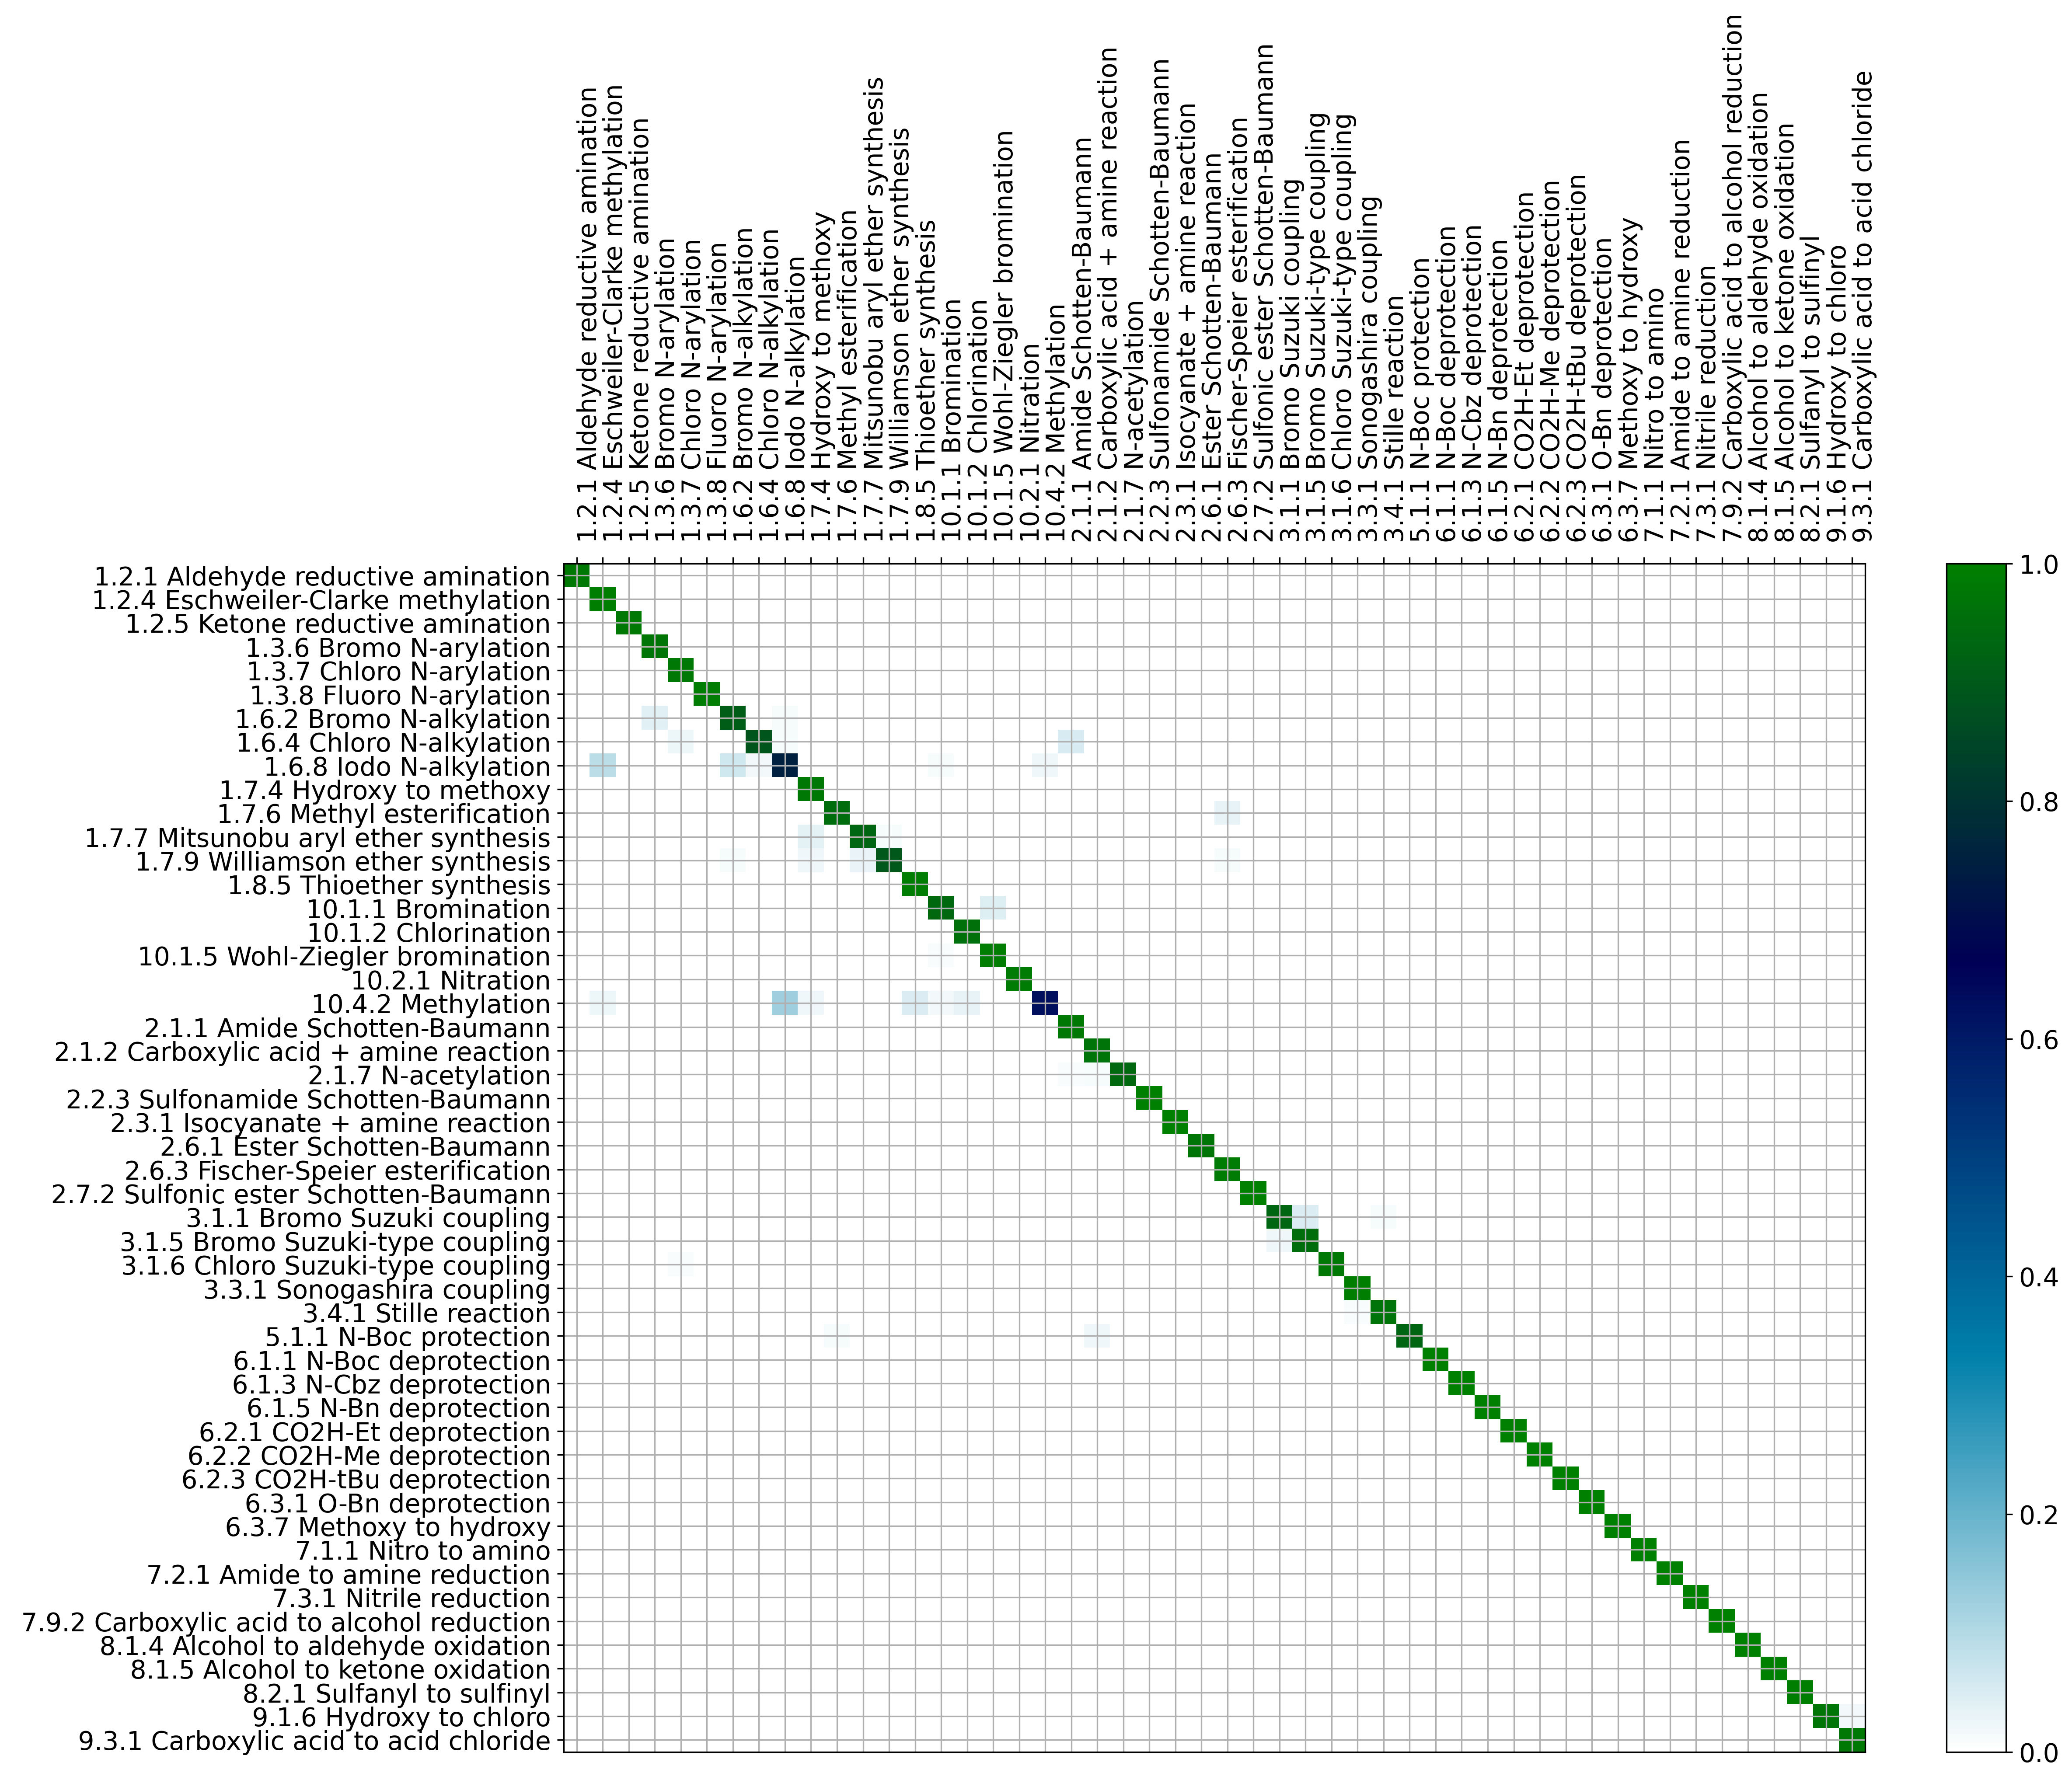

In [11]:
utilsFunctions.labelled_cmat(cmat_rFP_agentFeature,rtypes,figsize=(16,12), labelExtras=names_rTypes)

#### Second: test the agent Morgan2 FPs

Load the FPs (reaction FP and agent Morgan2 FP)

In [14]:
infile = gzip.open(dataDir+"reaction_FPs_agentMG2FPs_training_test_set_patent_data.pkl.gz", 'rb')

lineNo=0
fps=[]
idx=0
while 1:
    lineNo+=1
    try:
        lbl,cls,fp_woA,fp_MG2_agents = cPickle.load(infile)        
    except EOFError:
        break
    fps.append([idx,lbl,cls,fp_woA,fp_MG2_agents])
    idx+=1
    if not lineNo%10000:
        print("Done "+str(lineNo))

Done 10000
Done 20000
Done 30000
Done 40000
Done 50000


Build the combination of reaction FP and agent Morgan2 FP. Split the FPs in training (20 %) and test data (80 %) per recation type (200, 800)

In [15]:
random.seed(0xd00f)
indices=list(range(len(fps)))
random.shuffle(indices)

nActive=200
fpsz=2048 # the FPs bit size for converting the FPs to a numpy array
#fpsz=4096

trainFps_rFP_agentMG2=[]
trainActs=[]
testFps_rFP_agentMG2=[]
testActs=[]

print('building fp collection')

rtypes=sorted(list(reaction_types))
for i,klass in enumerate(rtypes):
    actIds = [x for x in indices if fps[x][2]==klass]
    for x in actIds[:nActive]:
        np1 = utilsFunctions.hashedFPToNP(fps[x][3],fpsz)
        np2 = utilsFunctions.fpToNP(fps[x][4],fpsz)
        trainFps_rFP_agentMG2 += [np.concatenate([np1, np2])]
    trainActs += [i]*nActive
    nTest=len(actIds)-nActive
    for x in actIds[nActive:]:
        np1 = utilsFunctions.hashedFPToNP(fps[x][3],fpsz)
        np2 = utilsFunctions.fpToNP(fps[x][4],fpsz)
        testFps_rFP_agentMG2 += [np.concatenate([np1, np2])]
    testActs += [i]*nTest

building fp collection


In [16]:
print('training model')
rf_cls = RandomForestClassifier(n_estimators=200, max_depth=25,random_state=23,n_jobs=1)
result_rf_rFP_agentMG2 = rf_cls.fit(trainFps_rFP_agentMG2,trainActs)

training model


In [18]:
cmat_rFP_agentMG2 = utilsFunctions.evaluateModel(result_rf_rFP_agentMG2, testFps_rFP_agentMG2, testActs, rtypes, names_rTypes)

ID  recall    prec F-score      reaction class
 0  0.9875  0.9814  0.9844     1.2.1 Aldehyde reductive amination
 1  0.9925  0.8510  0.9163     1.2.4 Eschweiler-Clarke methylation
 2  0.9800  0.9643  0.9721     1.2.5 Ketone reductive amination
 3  0.9725  0.9430  0.9575     1.3.6 Bromo N-arylation
 4  0.9712  0.9441  0.9575     1.3.7 Chloro N-arylation
 5  0.9888  0.9670  0.9778     1.3.8 Fluoro N-arylation
 6  0.9113  0.8794  0.8950     1.6.2 Bromo N-alkylation
 7  0.8862  0.9633  0.9232     1.6.4 Chloro N-alkylation
 8  0.7238  0.8428  0.7787     1.6.8 Iodo N-alkylation
 9  0.9725  0.9317  0.9517     1.7.4 Hydroxy to methoxy
10  0.9875  0.9611  0.9741     1.7.6 Methyl esterification
11  0.8600  0.9815  0.9167     1.7.7 Mitsunobu aryl ether synthesis
12  0.9113  0.9181  0.9147     1.7.9 Williamson ether synthesis
13  0.9825  0.9346  0.9580     1.8.5 Thioether synthesis
14  0.9500  0.9744  0.9620    10.1.1 Bromination
15  0.9663  0.9508  0.9585    10.1.2 Chlorination
16  1.0000  0.9804

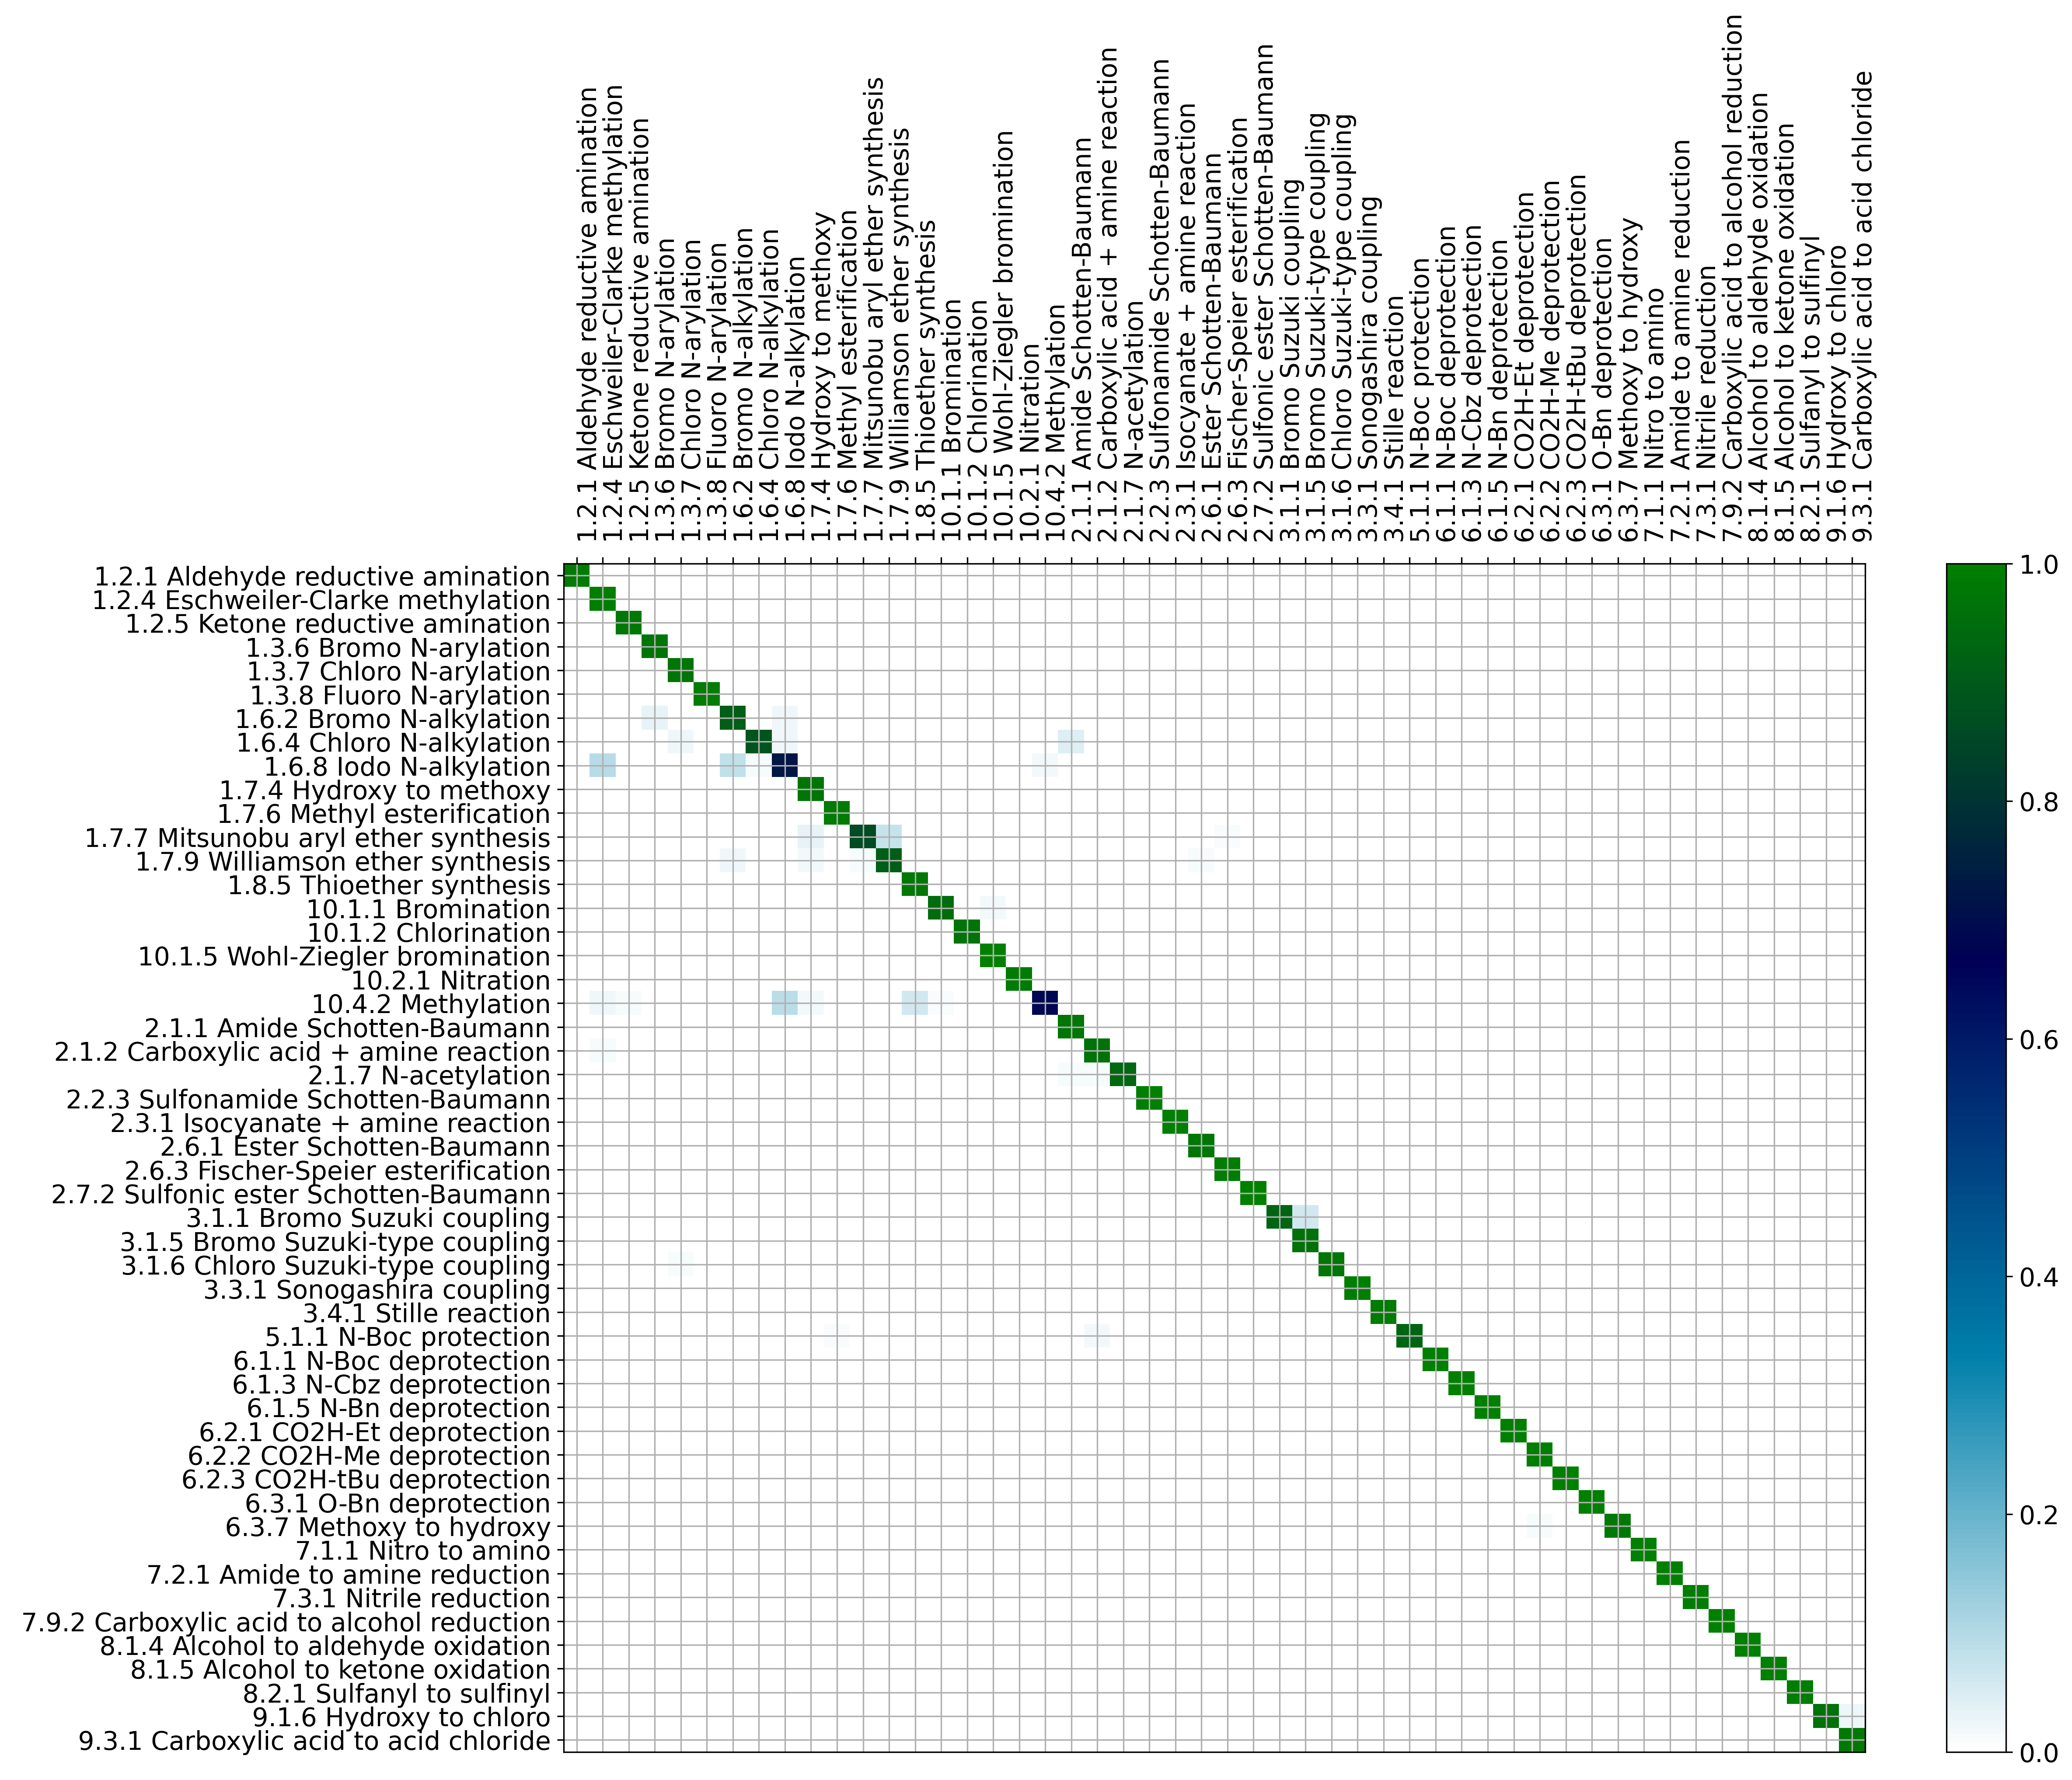

In [19]:
utilsFunctions.labelled_cmat(cmat_rFP_agentMG2,rtypes,figsize=(16,12),labelExtras=names_rTypes)

#### Third: test the agent dictionary-based FP

Load the FPs (reaction FP and agent dictionary-based FP)

In [20]:
infile = gzip.open(dataDir+"reaction_FPs_agentDictBasedFPs_training_test_set_patent_data.pkl.gz", 'rb')

lineNo=0
fps=[]
idx=0
while 1:
    lineNo+=1
    try:
        lbl,cls,fp_woA,fp_dictinarybased_agents = cPickle.load(infile)        
    except EOFError:
        break
    fps.append([idx,lbl,cls,fp_woA,fp_dictinarybased_agents])
    idx+=1
    if not lineNo%10000:
        print("Done "+str(lineNo))

Done 10000
Done 20000
Done 30000
Done 40000
Done 50000


In [21]:
random.seed(0xd00f)
indices=list(range(len(fps)))
random.shuffle(indices)

nActive=200
fpsz=2048 # the FPs bit size for converting the FPs to a numpy array
#fpsz=4096

trainFps_rFP_agentDictBased=[]
trainActs=[]
testFps_rFP_agentDictBased=[]
testActs=[]

print('building fp collection')

rtypes=sorted(list(reaction_types))
for i,klass in enumerate(rtypes):
    actIds = [x for x in indices if fps[x][2]==klass]
    for x in actIds[:nActive]:
        np1 = utilsFunctions.hashedFPToNP(fps[x][3],fpsz)
        np2 = utilsFunctions.fpDictToNP(fps[x][4])
        trainFps_rFP_agentDictBased += [np.concatenate([np1, np2])]
    trainActs += [i]*nActive
    nTest=len(actIds)-nActive
    for x in actIds[nActive:]:
        np1 = utilsFunctions.hashedFPToNP(fps[x][3],fpsz)
        np2 = utilsFunctions.fpDictToNP(fps[x][4])
        testFps_rFP_agentDictBased += [np.concatenate([np1, np2])]
    testActs += [i]*nTest

building fp collection


In [22]:
print('training model')
rf_cls = RandomForestClassifier(n_estimators=200, max_depth=25,random_state=23,n_jobs=1)
result_rf_rFP_agentDictBased = rf_cls.fit(trainFps_rFP_agentDictBased,trainActs)

training model


In [23]:
cmat_rFP_agentDictBased = utilsFunctions.evaluateModel(result_rf_rFP_agentDictBased, testFps_rFP_agentDictBased, testActs, rtypes, names_rTypes)

ID  recall    prec F-score      reaction class
 0  0.9762  0.9799  0.9781     1.2.1 Aldehyde reductive amination
 1  0.9938  0.8377  0.9091     1.2.4 Eschweiler-Clarke methylation
 2  0.9812  0.9691  0.9752     1.2.5 Ketone reductive amination
 3  0.9688  0.9463  0.9574     1.3.6 Bromo N-arylation
 4  0.9775  0.9298  0.9531     1.3.7 Chloro N-arylation
 5  0.9888  0.9646  0.9765     1.3.8 Fluoro N-arylation
 6  0.9087  0.9261  0.9174     1.6.2 Bromo N-alkylation
 7  0.8825  0.9376  0.9092     1.6.4 Chloro N-alkylation
 8  0.7362  0.8249  0.7781     1.6.8 Iodo N-alkylation
 9  0.9825  0.9247  0.9527     1.7.4 Hydroxy to methoxy
10  0.9888  0.9875  0.9881     1.7.6 Methyl esterification
11  0.9300  0.9700  0.9496     1.7.7 Mitsunobu aryl ether synthesis
12  0.9012  0.9691  0.9339     1.7.9 Williamson ether synthesis
13  0.9925  0.9452  0.9683     1.8.5 Thioether synthesis
14  0.9187  0.9646  0.9411    10.1.1 Bromination
15  0.9537  0.9526  0.9532    10.1.2 Chlorination
16  0.9912  0.9253

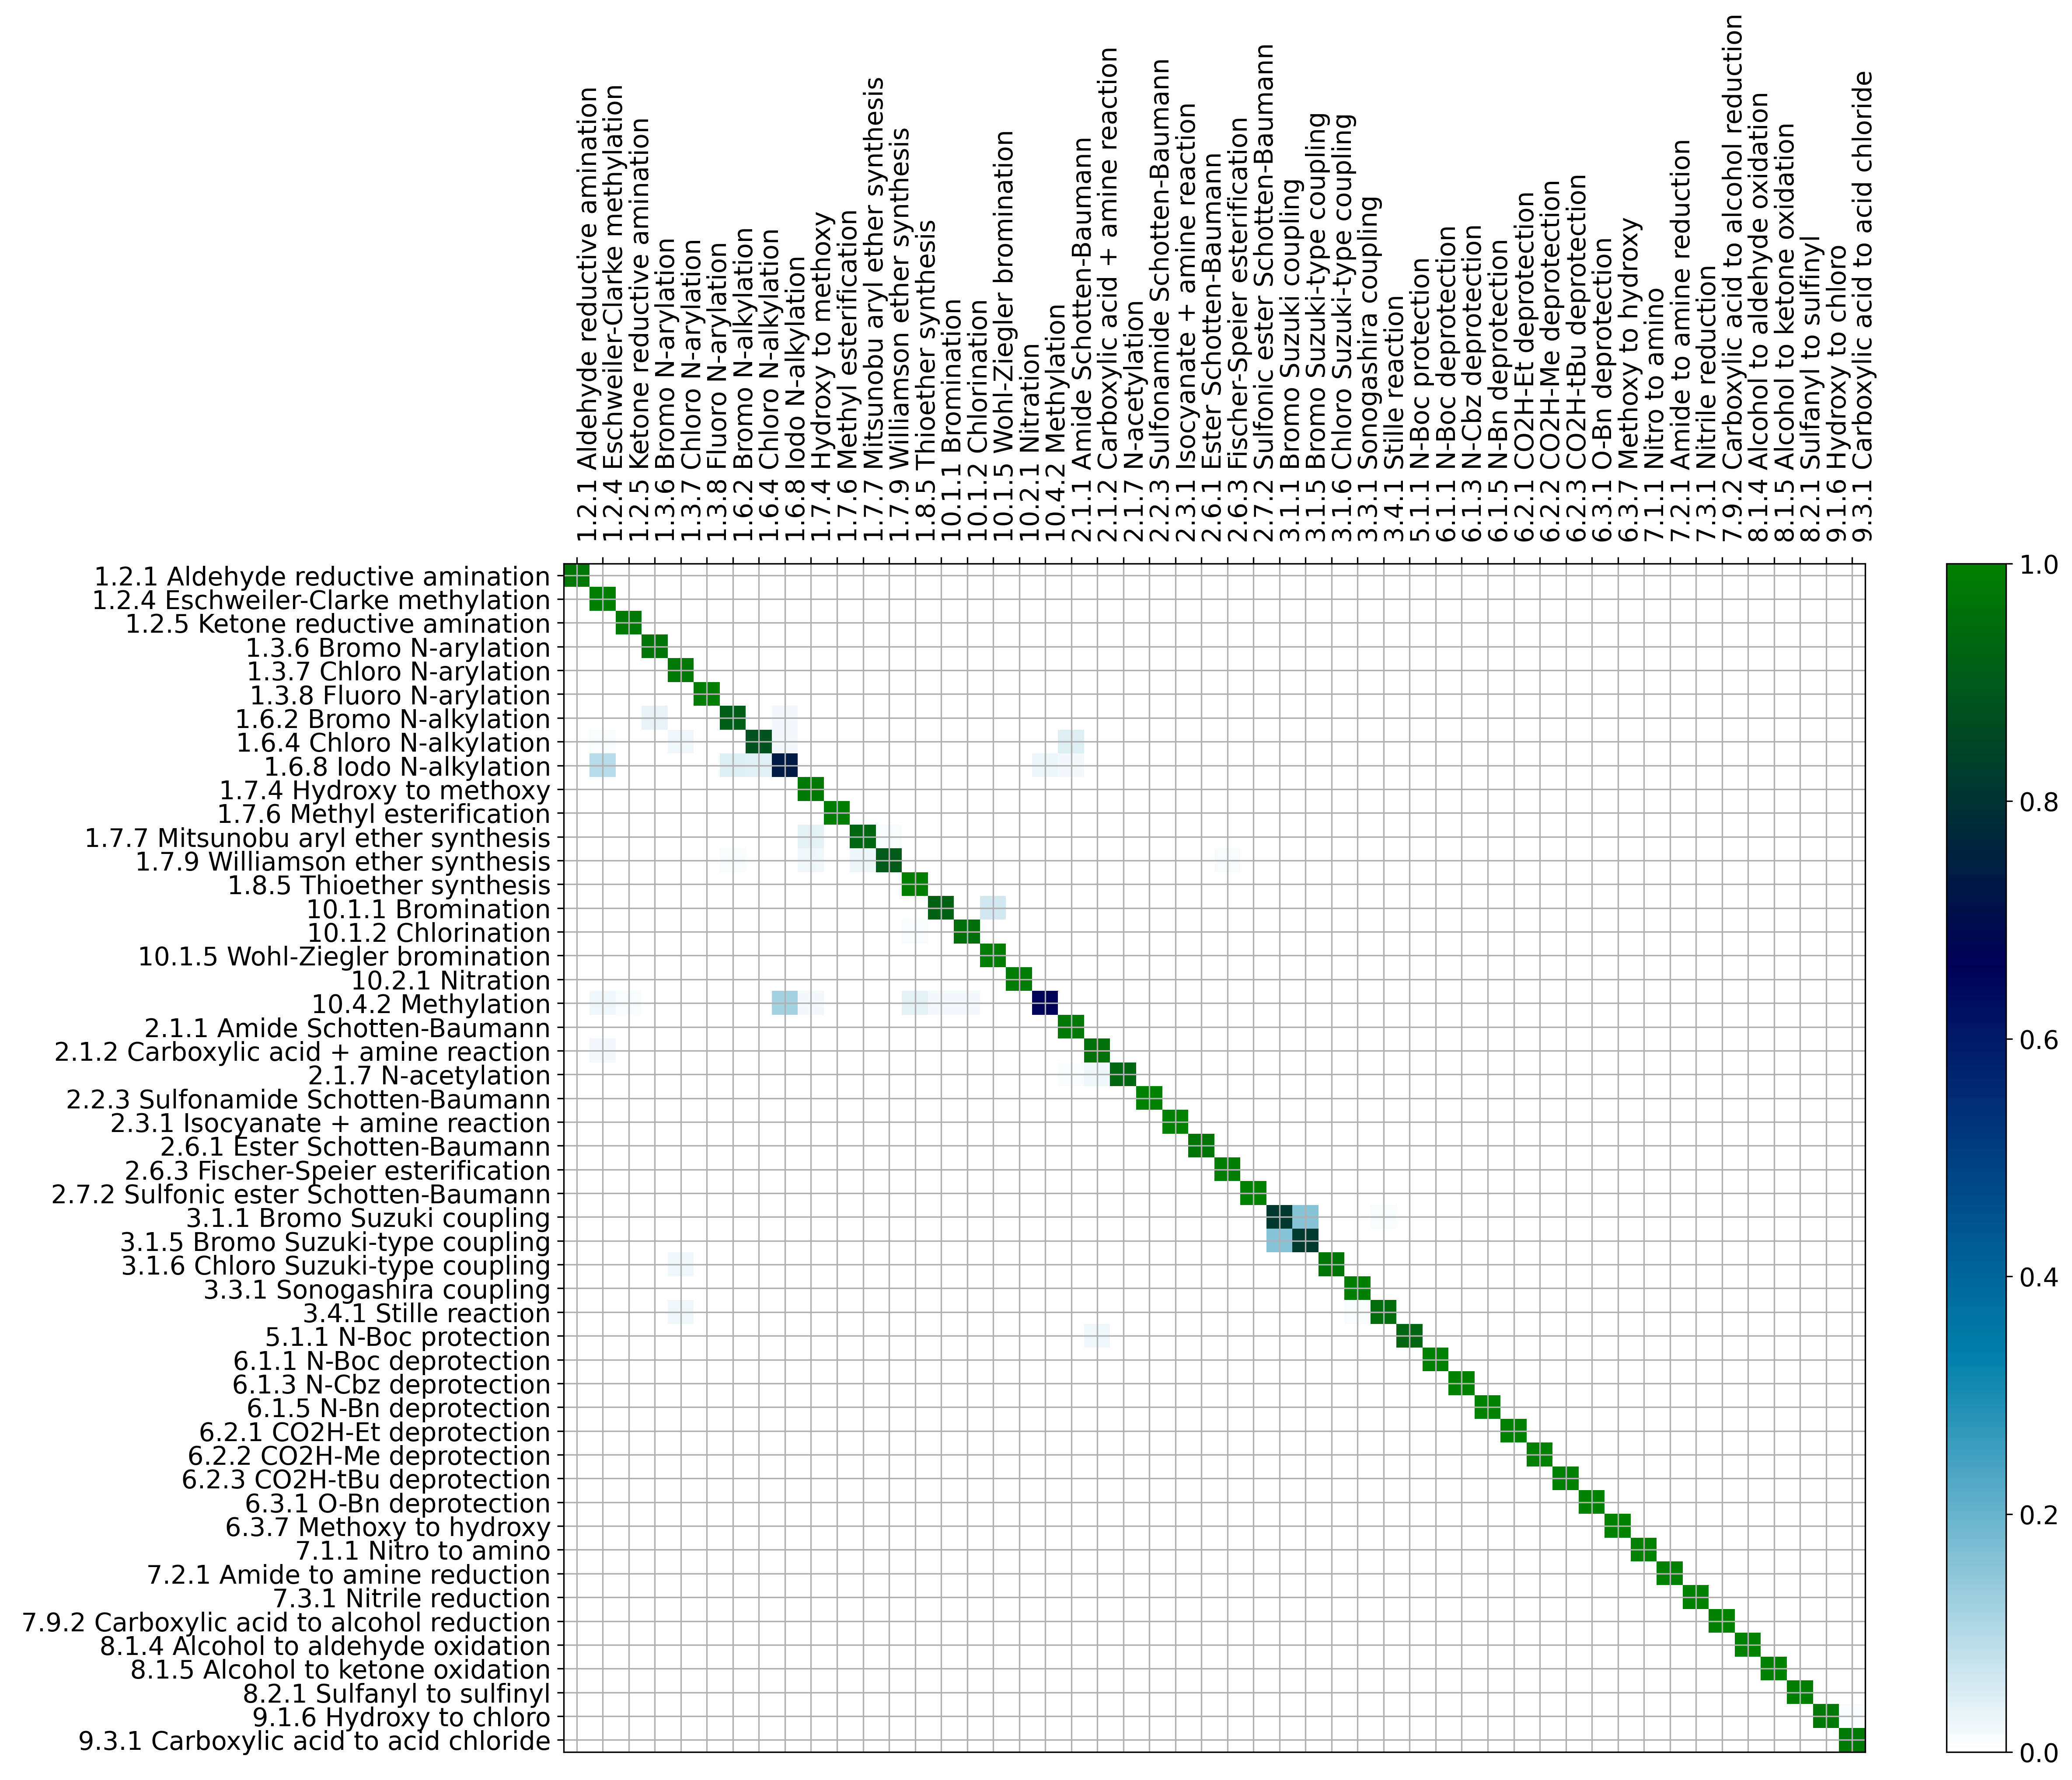

In [24]:
utilsFunctions.labelled_cmat(cmat_rFP_agentDictBased,rtypes,figsize=(16,12),labelExtras=names_rTypes)